In [472]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from sklearn.datasets import load_iris


class Encoder(nn.Module):
    """
    Responsible for generating from q(z|x) distribution: gaussian with diagonal covariance matrix
    with parameters (both means and standard deviations) given by multilayer perceptron.
    """
    def __init__(self, n_in, dim):
        super().__init__()
        self.mean = None
        self.sd = None
        hidden_dim = 256
        self.encode = nn.Sequential(
            nn.Linear(n_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.encode_mean = nn.Linear(hidden_dim, dim)
        self.encode_sd = nn.Sequential(
            nn.Linear(hidden_dim, dim),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encode(x)
        self.mean = self.encode_mean(z)
        self.sd = self.encode_sd(z) + 0.00001
        assert self.mean.shape == self.sd.shape
        return self.mean + self.sd * torch.randn_like(self.sd)
    
    def deterministic_forward(self, x):
        z = self.encode(x)
        return self.encode_mean(z)


class Decoder(nn.Module):
    def __init__(self, dim, n_out):
        super().__init__()
        self.a = nn.Parameter(torch.tensor([0.001]).float(), requires_grad=True)
        self.b = nn.Parameter(torch.tensor([0.]).float(), requires_grad=True)
        # self.ro = nn.Parameter(torch.tensor([0]), requires_grad=True)
#         self.sigma_1 = nn.Parameter(torch.tensor([0]), requires_grad=True)
#         self.sigma_2 = nn.Parameter(torch.tensor([0]), requires_grad=True)

    def forward(self, z):
        x1 = z
        x2 = self.a * z + self.b
        x = torch.stack([x1, x2], dim=1).view(-1, 2)
        return x

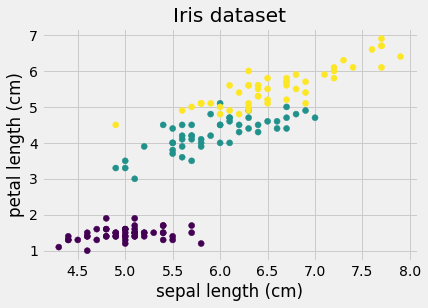

In [473]:
iris = load_iris()
x_np = iris["data"][:, [0, 2]]
y_np = iris["target"]
plt.scatter(x_np[:, 0], x_np[:, 1], c=y)
plt.xlabel("sepal length (cm)")
plt.ylabel("petal length (cm)")
plt.title("Iris dataset");

In [474]:
x = torch.tensor(x_np).float()

In [475]:
encoder = Encoder(2, 1)
decoder = Decoder(1, 2)

(476.3255615234375, 98.5029525756836, 3778.232177734375)

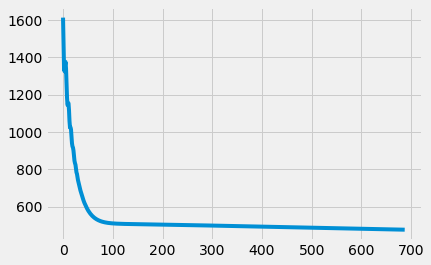

In [476]:
lr = 0.01

iris = load_iris()
x_np = iris["data"][:, [0, 2]]
y_np = iris["target"]
x = torch.tensor(x_np).float()

data_dim = 2
hidden_dim = 1

encoder = Encoder(data_dim, hidden_dim)
decoder = Decoder(hidden_dim, data_dim)

mse = nn.MSELoss()
optimizer = optim.Adam((*encoder.parameters(), *decoder.parameters()), lr=lr)

tol = 1e-2
losses = []
while True:
    optimizer.zero_grad()
    z = encoder(x)
    rec = decoder(z)
    rec_loss = torch.sum((x - rec)**2) / 2
    kl_loss = (encoder.sd**2 + (encoder.mean)**2 - 2*torch.log(encoder.sd) - 1).sum() / 2
    loss = rec_loss + 0.1*kl_loss
    if losses and abs(loss.item() - losses[-1]) < tol:
        break
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses[10:])
losses[-1], rec_loss.item(), kl_loss.item()

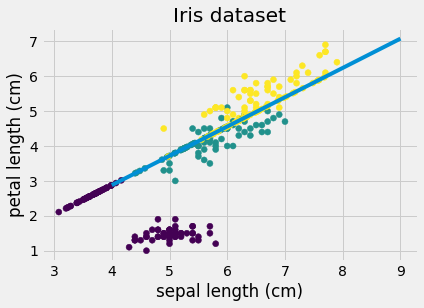

In [477]:
plt.scatter(x_np[:, 0], x_np[:, 1], c=y)
x_values = np.linspace(4,9,100)
y_values = decoder.a.item() * x_values + decoder.b.item()
plt.plot(x_values, y_values)

z = encoder.deterministic_forward(x)
x_model = decoder(z).detach().numpy()
plt.scatter(x_model[:, 0], x_model[:, 1], c=y)

plt.xlabel("sepal length (cm)")
plt.ylabel("petal length (cm)")
plt.title("Iris dataset");